In [7]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
import warnings
warnings.filterwarnings('ignore')
import calendar

In [8]:
import chart_studio.plotly as py
from plotly import figure_factory as ff
from plotly import express as px
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objects as go

init_notebook_mode(connected=True)
cf.go_offline()

In [9]:

df = pd.read_csv('.\Cookbook Reviews.csv')
df.head(2)


,rec_no,rec_cd,rec_nm,cmt_id,user_id,user_nm,user_reput,timestamp,response_no,upvotes,downvotes,ratings,max_rating,comment
0,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2G3aneMRgRMZwXqIHmSdXSG1hEM,u_9iFLIhMa8QaG,Jeri326,1,1665619889,0,0,0,5,527,"I tweaked it a little, removed onions because ..."
1,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2FsPC83HtzCsQAtOxlbL6RcaPbY,u_Lu6p25tmE77j,Mark467,50,1665277687,0,7,0,5,724,Bush used to have a white chili bean and it ma...


In [10]:
len(df)

18182

In [11]:
datapoint = df[~(df['ratings']==0)].reset_index(drop=True)

renamed_cols = {
    'rec_nm':'recipe',
    'user_reput': 'user_behavior',
    'response_no': 'comment_response'
}
datapoint.rename(columns=renamed_cols, inplace=True)

datapoint['datetime'] = pd.to_datetime(datapoint['timestamp'], unit='s')
datapoint['year'] =datapoint['datetime'].dt.year

month_dict = {i: calendar.month_name[i][:3] for i in range(1, 13)}
datapoint['month'] = datapoint['datetime'].dt.month#.map(month_dict)

drop_cols = ['rec_cd', 'rec_no', 'cmt_id', 'user_id', 'user_nm', 'timestamp', 'datetime']
datapoint.drop(columns=drop_cols, inplace=True)
datapoint.drop_duplicates(inplace=True)
datapoint.dropna(inplace=True)
datapoint.head()

,recipe,user_behavior,comment_response,upvotes,downvotes,ratings,max_rating,comment,year,month
0,Creamy White Chili,1,0,0,0,5,527,"I tweaked it a little, removed onions because ...",2022,10
1,Creamy White Chili,50,0,7,0,5,724,Bush used to have a white chili bean and it ma...,2022,10
2,Creamy White Chili,10,0,3,0,5,710,I have a very complicated white chicken chili ...,2022,9
3,Creamy White Chili,1,0,3,1,5,518,amazing! my boyfriend loved it so much! going ...,2022,8
4,Creamy White Chili,1,0,11,0,5,833,Wow!!! This recipe is excellent as written!! ...,2022,2


In [12]:
len(datapoint)

16235

In [13]:
def text_polarity(text):
    return TextBlob(text).sentiment.polarity

def text_sentiment(text):
    score = text_polarity(text)
    if score<0:
        return 'negative'
    elif score==0: 
        return 'neutral'
    else:
        return 'positive'


datapoint['comment'] = datapoint['comment'].astype(str)
datapoint['sentiment'] = datapoint['comment'].apply(text_sentiment)

In [14]:
len(datapoint)

16235

In [15]:
from sklearn.utils import shuffle

def filter_votes(datapoint, threshold=3)-> pd.DataFrame:    
    up_voted = shuffle(datapoint[datapoint.upvotes>datapoint.downvotes], random_state=43)
    eq_voted = shuffle(datapoint[datapoint.upvotes==datapoint.downvotes], random_state=43)
    down_voted = shuffle(datapoint[datapoint.upvotes<datapoint.downvotes], random_state=43)
    
    return shuffle(pd.concat(
        [down_voted[down_voted.ratings<=threshold],
         up_voted[up_voted.ratings>threshold],
         eq_voted], axis=0), random_state=3)

def filter_sentiments(datapoint, threshold=3) -> pd.DataFrame:
    lt_threshold = datapoint[datapoint.ratings<=threshold]
    gt_threshold = datapoint[datapoint.ratings>threshold]
    pos_sentiment = shuffle(gt_threshold[~(gt_threshold.sentiment=='negative')], random_state=3)
    neg_sentiment = shuffle(lt_threshold[~(lt_threshold.sentiment=='positive')], random_state=3)
    
    data_frame = shuffle(pd.concat([neg_sentiment, pos_sentiment], axis=0), random_state=3)
    return data_frame

modelpoint = filter_votes(datapoint)
modelpoint = filter_sentiments(modelpoint)
modelpoint = shuffle(modelpoint)
modelpoint.head()

,recipe,user_behavior,comment_response,upvotes,downvotes,ratings,max_rating,comment,year,month,sentiment
8660,Flavorful Pot Roast,1,0,0,0,5,100,Very Very good! Even my mother in law who is a...,2021,6,positive
15447,Tennessee Peach Pudding,1,0,0,0,5,100,Nothing like peach season in Colorado! I love ...,2021,6,positive
3460,Enchilada Casser-Ole!,1,0,0,0,5,100,"Sorry, but I didn&#39;t use any fat free stuff...",2021,6,positive
9796,Chunky Apple Cake,1,0,0,0,5,100,So yummy and easy to make! Everyone loved it!,2021,6,positive
12028,Slow-Cooker Lasagna,1,0,0,0,5,100,wow..cooking lasagne is always a pain.but now ...,2021,6,neutral


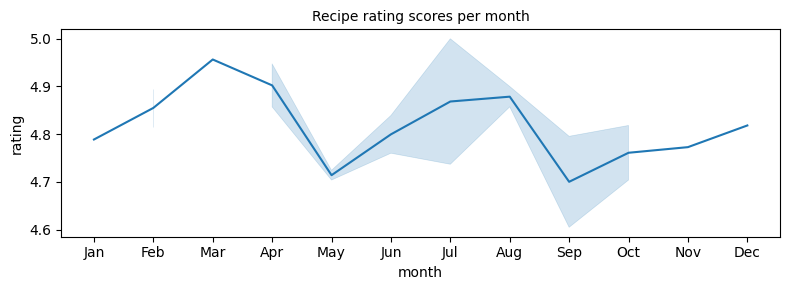

In [16]:
sub_df4 = modelpoint.groupby(['month', 'year'],as_index=False)['ratings'].mean().sort_values('month')
sub_df4.month = sub_df4.month.map(month_dict)
fig, ax = plt.subplots(1,1, figsize=(8,3))

plt.style.use('ggplot')
filter_by_year = 2021

sns.lineplot(sub_df4, x='month', y='ratings', ax=ax)

ax.set_ylabel('rating')
ax.set_xlabel('month')
ax.set_title('Recipe rating scores per month', fontdict=dict(size=10))
plt.tight_layout()
plt.show()

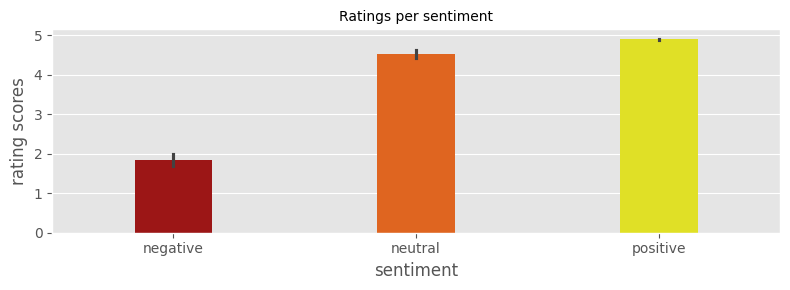

In [17]:
sub_df1 = modelpoint.groupby(['recipe', 'sentiment'], as_index=False)['ratings'].mean()
fig, ax = plt.subplots(1,1, figsize=(8,3))

plt.style.use('ggplot')
# sns.set_palette('plasma')
sns.barplot(sub_df1, y='ratings', x='sentiment', palette='hot', hue='sentiment', ax=ax, gap=0.6)

ax.set_ylabel('rating scores')
# ax.set_xlabel('Sentiment')
ax.set_title('Ratings per sentiment', fontdict=dict(size=10))
plt.tight_layout()
plt.show()


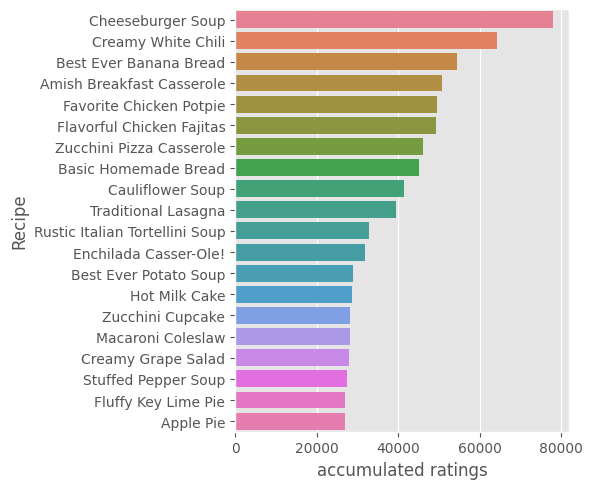

In [18]:
recipe_df = modelpoint.groupby(['recipe'], as_index=False)['max_rating'].sum().sort_values('max_rating', ascending=False).reset_index(drop=True)
fig, ax = plt.subplots(1,1, figsize=(6,5))

plt.style.use('ggplot')
# sns.set_palette('')
sns.barplot(recipe_df.iloc[:20], x='max_rating', y='recipe', hue='recipe', ax=ax)

ax.set_ylabel('Recipe')
ax.set_xlabel('accumulated ratings')
# ax.set_title('Recipe rating scores by sentiment')
plt.tight_layout()
plt.show()

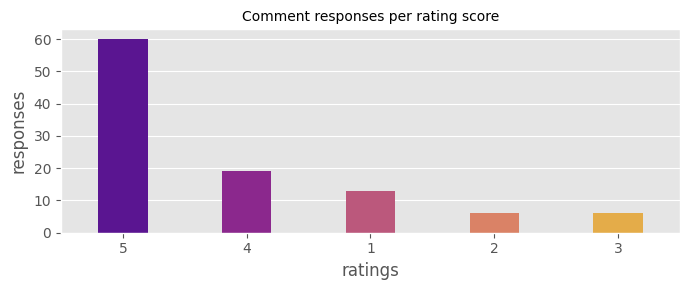

In [19]:
temp_modelpoint = modelpoint.copy()
temp_modelpoint['ratings'] = temp_modelpoint['ratings'].astype(str)
recipe_df = temp_modelpoint.groupby(['ratings'], as_index=False)['comment_response'].sum().sort_values('comment_response', ascending=False).reset_index(drop=True)
fig, ax = plt.subplots(1,1, figsize=(7,3))

plt.style.use('ggplot')
# sns.set_palette('')
sns.barplot(recipe_df.iloc[:20], y='comment_response', x='ratings', palette='plasma',hue='ratings', gap=0.5, ax=ax)

ax.set_ylabel('responses')
ax.set_xlabel('ratings')
ax.set_title('Comment responses per rating score', fontdict=dict(size=10))
plt.tight_layout()
plt.show()

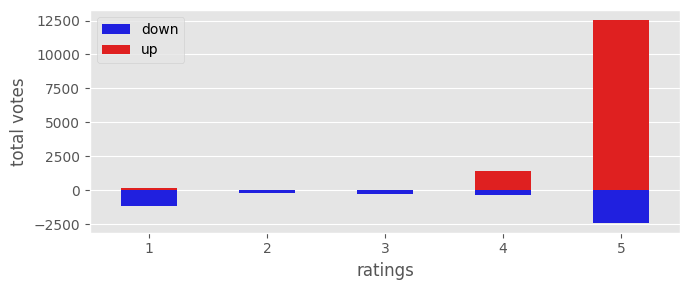

In [20]:
up_votes = modelpoint.groupby('ratings')['upvotes'].sum()
down_votes = modelpoint.groupby('ratings')['downvotes'].sum()
res_comments = modelpoint.groupby('ratings')['comment_response'].sum()
res_votes = pd.merge(up_votes, down_votes, how='inner', on='ratings').merge(res_comments, on='ratings', how='inner').reset_index(drop=False)
res_votes= res_votes.sort_values('ratings', ascending=False)
res_votes['downvotes'] = res_votes['downvotes'].map(lambda value: -value)
fig, ax = plt.subplots(1,1, figsize=(7,3))

plt.style.use('ggplot')
sns.barplot(res_votes, x='ratings', y='downvotes', color='blue', gap=0.4,ax=ax, label='down')
sns.barplot(res_votes, x='ratings', y='upvotes', color='red', gap=0.4, ax=ax, label='up')
plt.ylabel('total votes')
plt.tight_layout()
plt.show()

In [21]:
# df.rec_no.unique()
# df.rec_nm.nunique()
# Recipe with most listings

# Recipe with highest ratings
# Recipte with most positive reviews
# Recipte with least with most negative reviews
# Recipe with most reviews
# Recipe with lowest listings
# Recipe ratings overtime
# Recommended recipe
# Ratings disributions
# df.rec
# df

In [22]:
ratings_prop = modelpoint.ratings.value_counts(normalize=True).to_frame().reset_index()
# ratings_prop.head()
fig = px.pie(data_frame=ratings_prop,values='proportion',
             names='ratings', hole=0.4, width=600, height=300
             )
fig.update_layout(title='Review ratings distribution')
fig.update_legends(title='Ratings', )

In [23]:
ratings_prop = modelpoint.sentiment.value_counts(normalize=True).to_frame().reset_index()
# ratings_prop.head()
fig = px.pie(data_frame=ratings_prop,values='proportion',
             names='sentiment', hole=0.4, width=600, height=300
             )
fig.update_layout(title='Review ratings distribution')
fig.update_legends(title='Ratings', )

In [24]:
import nltk
import sklearn
import re
import contractions
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords
import string

In [25]:

stop_words = np.unique(list(ENGLISH_STOP_WORDS) + stopwords.words('english'))
lemma = WordNetLemmatizer()

model_point= modelpoint[['ratings', 'sentiment','comment']].dropna().copy()
model_point.head()

,ratings,sentiment,comment
8660,5,positive,Very Very good! Even my mother in law who is a...
15447,5,positive,Nothing like peach season in Colorado! I love ...
3460,5,positive,"Sorry, but I didn&#39;t use any fat free stuff..."
9796,5,positive,So yummy and easy to make! Everyone loved it!
12028,5,neutral,wow..cooking lasagne is always a pain.but now ...


In [4]:
import spacy
import spacy_cleaner
from spacy_cleaner.processing import removers, replacers, mutators
from spacy_cleaner.cleaners import Cleaner

In [5]:
nlp = spacy.load('en_core_web_sm')

new_stopwords = ['TIME', 'DATE', 'LOC','PERSON']
def remove_additional_stopword(text):
    text_list = text.split()
    for value in text_list:
        doc = nlp(value)
        for ent in doc.ents:
            if ent.label_ in new_stopwords:
                text_list.remove(ent.text)
    return ' '.join(text_list)

In [38]:
text_pipeline = spacy_cleaner.Cleaner(
    nlp,
    removers.remove_punctuation_token,
    removers.remove_number_token,
    removers.remove_stopword_token,
    mutators.mutate_lemma_token
)

def text_processor(s: str) -> str:
    text = s.lower()
    text = contractions.fix(text)
    text = ' '.join([word.strip() for word in re.findall(r'\w+',text)])
    text = re.sub(r'\d+', '', text)
    # text = remove_additional_stopword(text)
    text = ''.join(text_pipeline.clean([text]))
    text = ' '.join([word for word in text.split() if len(word)>2])
    return text


model_point['comment'] = model_point['comment'].astype(str)
model_point['clean_comment'] = model_point['comment'].map(text_processor)
model_point['tokens'] = model_point['clean_comment'].map(lambda s: s.split())

Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 15.36it/s]


In [40]:
model_point.head()

,ratings,sentiment,comment,clean_comment,tokens
8660,5,positive,Very Very good! Even my mother in law who is a...,good mother law tough critic love,"[good, mother, law, tough, critic, love]"
15447,5,positive,Nothing like peach season in Colorado! I love ...,like peach season colorado love way use large ...,"[like, peach, season, colorado, love, way, use..."
3460,5,positive,"Sorry, but I didn&#39;t use any fat free stuff...",sorry use fat free stuff brown beef onion drai...,"[sorry, use, fat, free, stuff, brown, beef, on..."
9796,5,positive,So yummy and easy to make! Everyone loved it!,yummy easy love,"[yummy, easy, love]"
12028,5,neutral,wow..cooking lasagne is always a pain.but now ...,wow cooking lasagne pain problem,"[wow, cooking, lasagne, pain, problem]"


In [41]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer

In [42]:
text_corpus = [word for sentence in model_point['tokens'] for word in sentence]

In [43]:
count_vector = CountVectorizer()
x_vectors = count_vector.fit_transform(text_corpus)

In [44]:
# count_vector.get_feature_names_out()
tfidf_transformer = TfidfTransformer()
x_tfidf = tfidf_transformer.fit_transform(x_vectors)

In [45]:
dimension = 2
lda = LDA(n_components=dimension)
lda_array = lda.fit_transform(x_tfidf)

In [46]:
components = [lda.components_[i] for i in range(len(lda.components_))]
features = count_vector.get_feature_names_out().tolist()
important_words = [sorted(features, key=lambda x: components[j][features.index(x)], reverse=True) for j in range(len(components))]
topics = [{word: i+1 for i, word in enumerate(important_words[index])} for index in range(len(important_words))]

In [47]:
import matplotlib.colors as mcolors
from wordcloud import WordCloud
from matplotlib import pyplot as plt

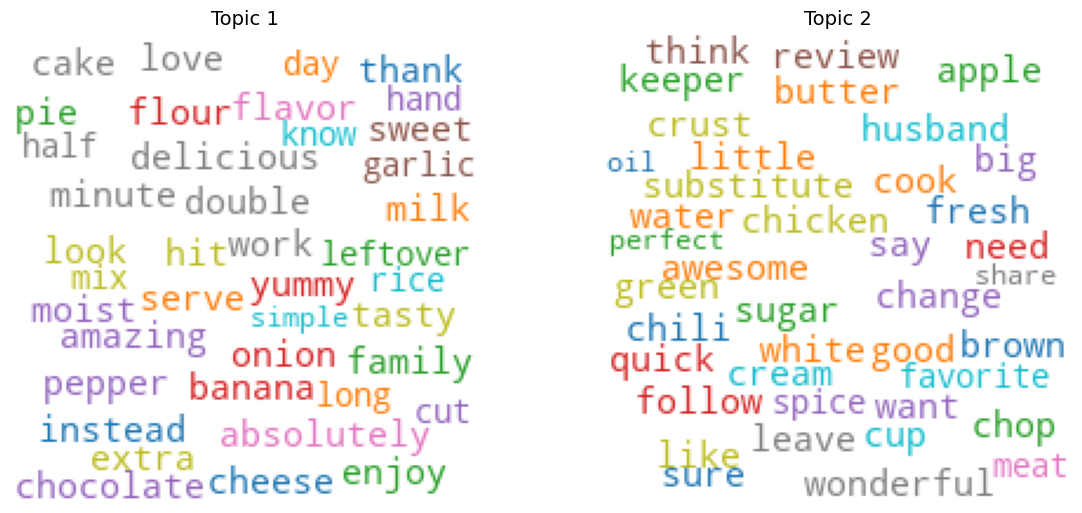

In [48]:
cols = [color for color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(
    stopwords=stop_words,
    background_color='white',
    max_font_size=15,
    max_words=40,
    colormap='tab10',
    width=200,
    height=200,
    random_state=42,
    prefer_horizontal=1
)


fig, axes = plt.subplots(1,2, figsize=(12,5))

for i, ax, in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    cloud.generate_from_frequencies(topics[i])
    plt.gca().imshow(cloud)
    plt.gca().axis('off')
    ax.set_title('Topic {}'.format(i+1), fontdict=dict(size=14))
    
plt.subplots_adjust(wspace=40, hspace=30)
plt.tight_layout()
plt.show()

#### Text Analysis

In [49]:
from nltk.tokenize import sent_tokenize

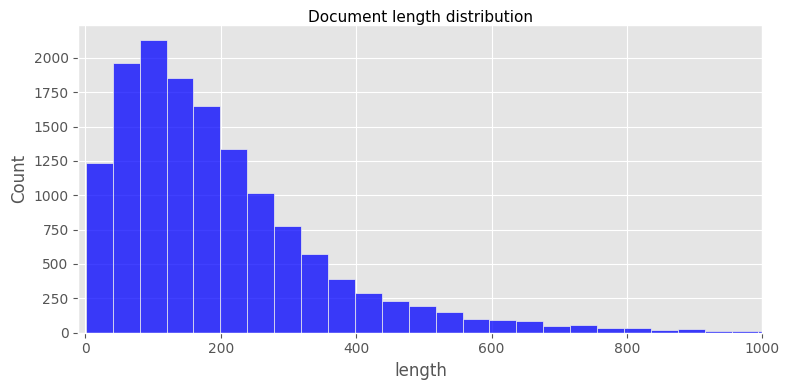

In [50]:
review_length = [len(x) for x in modelpoint['comment']]
fig, ax = plt.subplots(1, 1, figsize=(8,4))

sns.histplot(x=review_length, binwidth=40, color='blue')
plt.title('Document length distribution', fontdict=dict(size=11, weight='light'), pad=0.8)
plt.xlim(-10, 1000)
plt.xlabel('length')
plt.tight_layout()
plt.show()

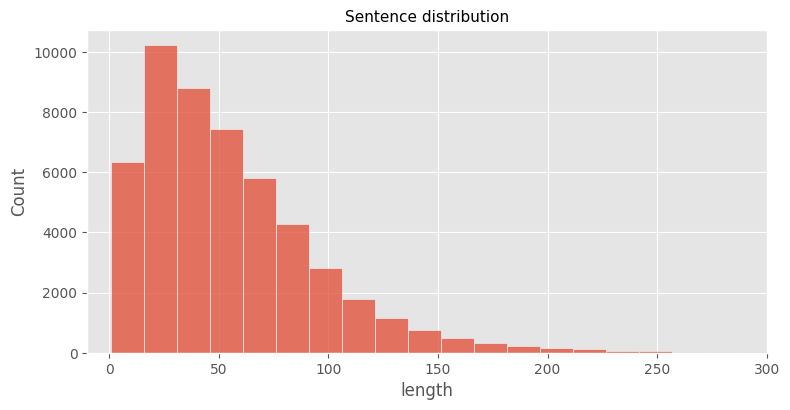

In [51]:
sentence_level = [sentence for doc in model_point['comment'] for sentence in sent_tokenize(doc,'english')]
sentence_length = [len(sent) for sent in sentence_level]
fig, ax = plt.subplots(1, 1, figsize=(8,4))

sns.histplot(x=sentence_length, binwidth=15)

plt.xlim(-10, 300)
plt.xlabel('length')
plt.tight_layout()
plt.title('Sentence distribution', fontdict=dict(size=11, weight='light'))
plt.show()

In [55]:
pos_modelpoint = model_point[model_point['sentiment']=='positive']
ne_modelpoint = model_point[model_point['sentiment']=='neutral']
neg_modelpoint = model_point[model_point['sentiment']=='negative']

In [56]:
sorted_pos = sorted({word: index+1 for tokens in pos_modelpoint['tokens'] for index, word in enumerate(tokens)}.items(), key=lambda item: item[1], reverse=True)
sorted_neg = sorted({word: index+1 for tokens in neg_modelpoint['tokens'] for index, word in enumerate(tokens)}.items(), key=lambda item: item[1], reverse=True)
sorted_ne = sorted({word: index+1 for tokens in ne_modelpoint['tokens'] for index, word in enumerate(tokens)}.items(), key=lambda item: item[1], reverse=True)

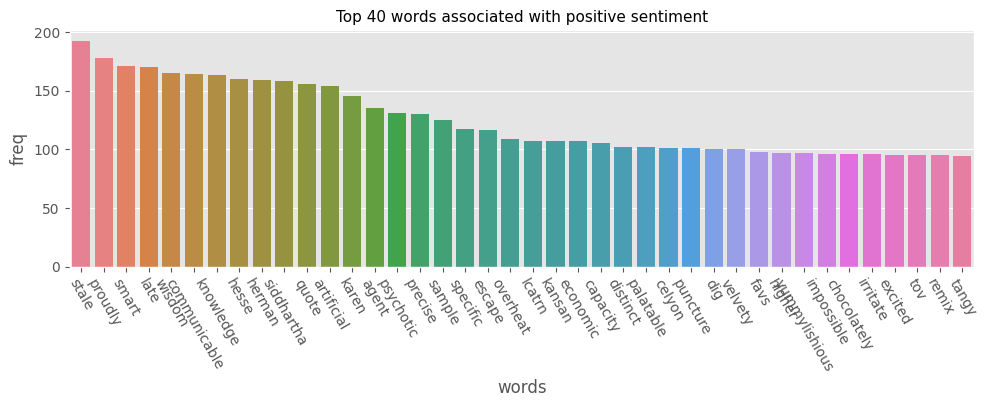

In [54]:
def plot_sentiment_words(words: list[str],sentiment_title: str, topn=40):
    x = [i for i, _ in words[:topn]]
    y = [i for _,i in words[:topn]]
    
    fig, ax = plt.subplots(1, 1, figsize=(10,4))
    sns.barplot(x=x, y=y, hue=x, ax=ax)

    plt.xticks(rotation=-60)
    plt.xlabel('words')
    plt.ylabel('freq')
    plt.tight_layout()
    plt.title(f'Top {topn} words associated with {sentiment_title} sentiment', fontdict=dict(size=11, weight='light'))
    plt.show()
    
plot_sentiment_words(sorted_pos, 'positive')

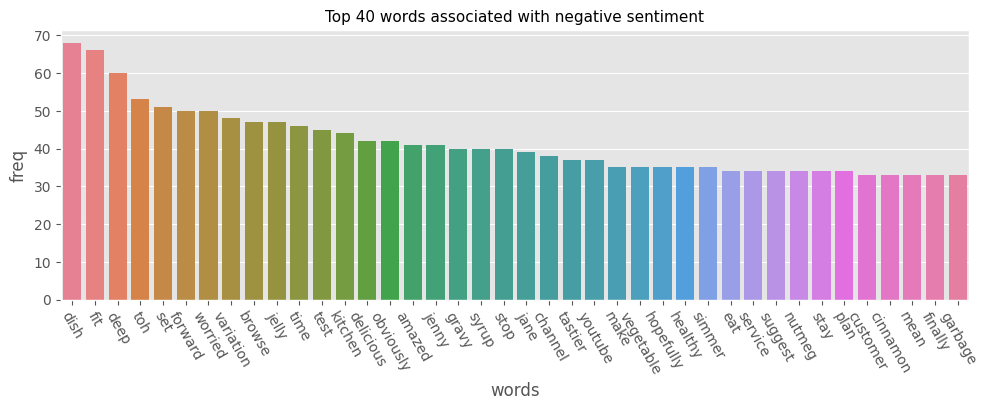

In [57]:
plot_sentiment_words(sorted_neg, 'negative')

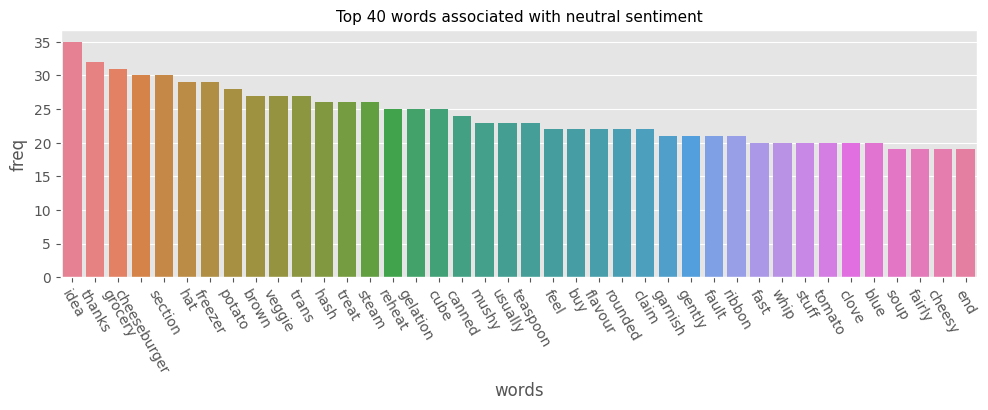

In [58]:
plot_sentiment_words(sorted_ne, 'neutral')

In [59]:
stars_4_to_5 = model_point[(model_point['ratings']==4) | (model_point['ratings']==5)]

stars_1_to_3 = model_point[(model_point['ratings']==1) |
                           (model_point['ratings']==3) |
                           (model_point['ratings']==3)]


sorted_4_to_5 = sorted({word: index+1 for tokens in stars_4_to_5['tokens'] for index, word in enumerate(tokens)}.items(), key=lambda item: item[1], reverse=True)
sorted_1_to_3 = sorted({word: index+1 for tokens in stars_1_to_3['tokens'] for index, word in enumerate(tokens)}.items(), key=lambda item: item[1], reverse=True)


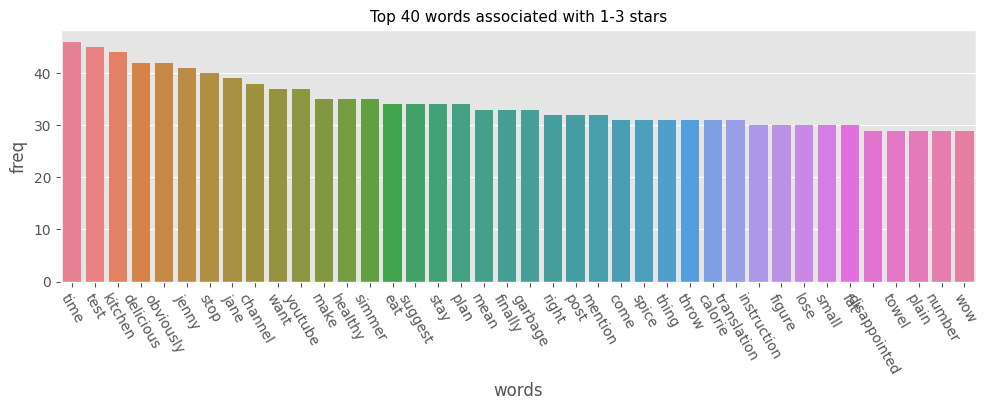

In [60]:
def plot_sentiment_words(words: list[str],rating_range: str, topn=40):
    x = [i for i, _ in words[:topn]]
    y = [i for _,i in words[:topn]]
    
    fig, ax = plt.subplots(1, 1, figsize=(10,4))
    sns.barplot(x=x, y=y, hue=x, ax=ax)

    plt.xticks(rotation=-60)
    plt.xlabel('words')
    plt.ylabel('freq')
    plt.tight_layout()
    plt.title(f'Top {topn} words associated with {rating_range} stars', fontdict=dict(size=11, weight='light'))
    plt.show()
    
plot_sentiment_words(sorted_1_to_3, '1-3')

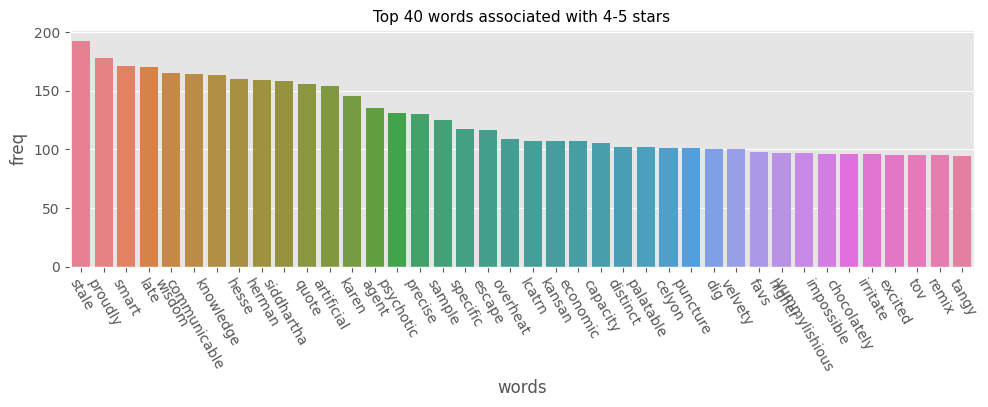

In [61]:
plot_sentiment_words(sorted_4_to_5, '4-5')

In [63]:
from wordcloud import WordCloud


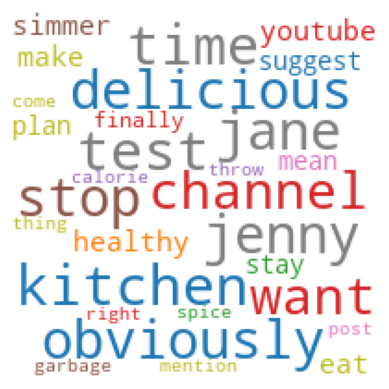

In [66]:
word_cloud = WordCloud(
    stopwords=stop_words,
    background_color='white',
    max_font_size=30,
    max_words=40,
    colormap='tab10',
    width=200,
    height=200,
    random_state=42,
    prefer_horizontal=1,
    min_font_size=10
)

word_cloud.generate_from_frequencies(dict(sorted_1_to_3))

plt.imshow(word_cloud)
plt.axis('off')
plt.show()

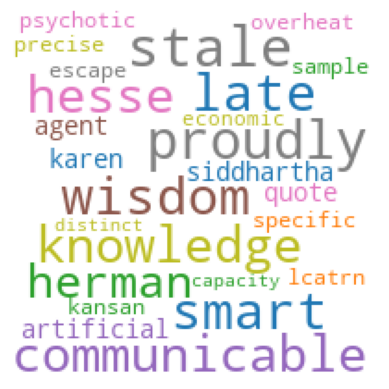

In [67]:
word_cloud = WordCloud(
    stopwords=stop_words,
    background_color='white',
    max_font_size=30,
    max_words=40,
    colormap='tab10',
    width=200,
    height=200,
    random_state=42,
    prefer_horizontal=1,
    min_font_size=10
)

word_cloud.generate_from_frequencies(dict(sorted_4_to_5))

plt.imshow(word_cloud)
plt.axis('off')
plt.show()

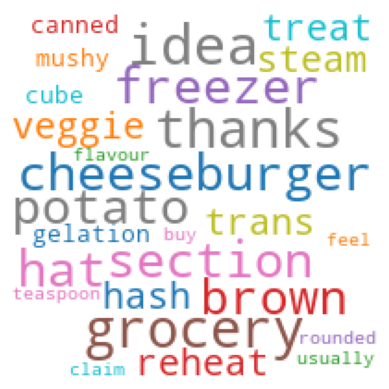

In [68]:
word_cloud = WordCloud(
    stopwords=stop_words,
    background_color='white',
    max_font_size=30,
    max_words=40,
    colormap='tab10',
    width=200,
    height=200,
    random_state=42,
    prefer_horizontal=1,
    min_font_size=10
)

word_cloud.generate_from_frequencies(dict(sorted_ne))

plt.imshow(word_cloud)
plt.axis('off')
plt.show()

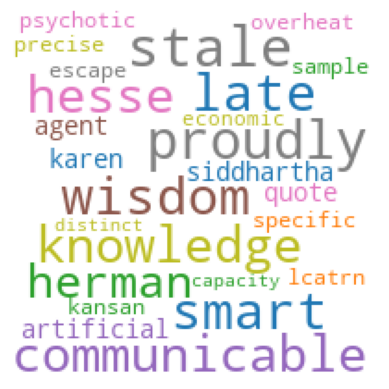

In [69]:
word_cloud = WordCloud(
    stopwords=stop_words,
    background_color='white',
    max_font_size=30,
    max_words=40,
    colormap='tab10',
    width=200,
    height=200,
    random_state=42,
    prefer_horizontal=1,
    min_font_size=10
)

word_cloud.generate_from_frequencies(dict(sorted_pos))

plt.imshow(word_cloud)
plt.axis('off')
plt.show()

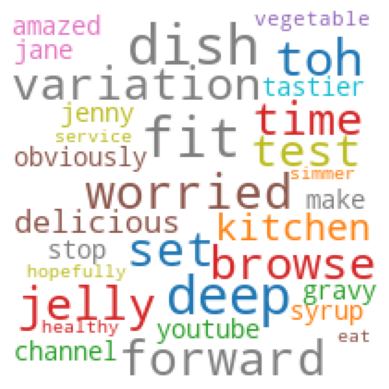

In [70]:
word_cloud = WordCloud(
    stopwords=stop_words,
    background_color='white',
    max_font_size=30,
    max_words=40,
    colormap='tab10',
    width=200,
    height=200,
    random_state=42,
    prefer_horizontal=1,
    min_font_size=10
)

word_cloud.generate_from_frequencies(dict(sorted_neg))

plt.imshow(word_cloud)
plt.axis('off')
plt.show()